In [51]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, plot_N3D, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_lil_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch, make_D_use
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir
from tools_lnd import interp2d,gen_D_fp_qr,gen_mov_trial_set

In [52]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'mem_motifs_small'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# net_name = 'lr7.0l2_w6.0_h-0.0_fdgo_fdanti'
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [53]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig1','fig1_two_task_interp',w_init)
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [54]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt


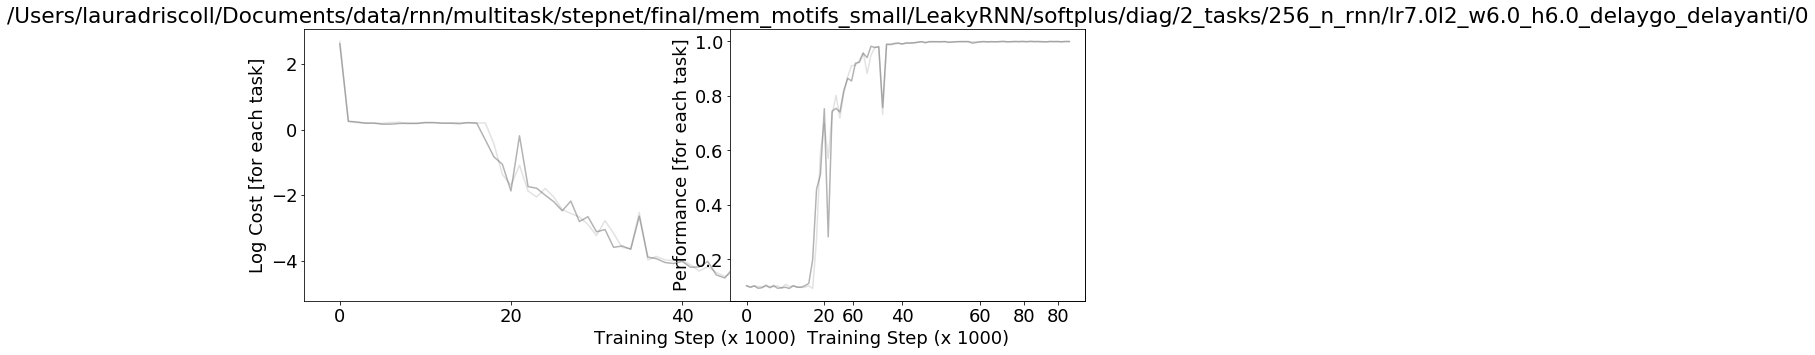

In [55]:
fig = plt.figure(figsize=(14, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')
task_list = hparams['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    
    ax1 = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)

    ax2 = fig.add_subplot(1,2,2)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)

ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')    
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
plt.title(m)
plt.show()    

In [6]:
# %matplotlib

In [7]:
# ########## X TASK ###########
# offset = 0
# t_set = [offset, offset]
# trial_num = [int(offset/4), int(offset/4)]

# rule_set = [5,2]
# epoch_set = ['fix1','fix1']
# linestyle = ['-','-']
# axs = 'pca_h'
# tol_q = 1e-6
# interp = True
# script_name = 'interp_tasks_small_init_stim'

# rule_axs = 1
# epoch = epoch_set[rule_axs]
# rule = rules_dict['all'][rule_set[rule_axs]]
# ti = trial_num[rule_axs]
# D_fix = make_D_use(m,rule,epoch,ti,axs)

# trial_set = gen_mov_trial_set(m,rule_set)
# D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,epoch_set,trial_num)
# D_diff = D_fp_qr[:,0]
# D_end = D_fp_qr[:,1]
# D_use = D_fp_qr[:,:2]

# interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = 1e-6,interp = interp,
#              cmap_grad = plt.get_cmap('plasma'),q_thresh = .000001,
#             n_skip_interps=1, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = figpath,
#          fig_size = 6,alpha_max = 1.2,title_y = .8, stability_thresh = 1.05)

In [8]:
# from tools_lnd import make_D_use, interp3d

# script_name = 'interp_tasks_small_init_mov'

# rule_set = [5,2]
# linestyle = ['-','-']
# axs = 'pca_h'
# tol_q = 1e-6
# interp = True
# trial_num = [0,0]
# t_set = [0,0]

# rule_axs = 1
# trial_set = gen_mov_trial_set(m,rule_set)
# D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)
# D_diff = D_fp_qr[:,0]
# D_end = D_fp_qr[:,1]
# D_use = D_fp_qr[:,:2]

# epoch_set = ['stim1','stim1']
# epoch = epoch_set[rule_axs]
# rule = rules_dict['all'][rule_set[rule_axs]]
# ti = trial_num[rule_axs]
# D_stim = make_D_use(m,rule,epoch,ti,axs)

# D_use = D_stim
# D_use[:,0] = -D_stim[:,0]
# D_use[:,1] = D_stim[:,1]
# # D_use[:,2] = D_fix[:,1]
# D_use[:,2] = D_fp_qr[:,0]
# # D_use[:,2] = w_out[:,2]

# interp = True
# fig_size = 5

# epoch_set = ['stim1','stim1']
# script_name = 'interp_tasks_small_init_stim'

# interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,plot_zero_plane = False, 
#          zlabel = 'Cntxt Endpt. Diff',ax_labels = [epoch, rule], stability_thresh = 1.05)

# D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,epoch_set,trial_num)
# D_go = D_stim
# D_go[:,2] = D_fp_qr[:,0]

# epoch_set = ['delay1','delay1']
# script_name = 'interp_tasks_small_init_mov'

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule],
#          zlabel = 'Memory Endpt. Diff',plot_zero_plane = False, stability_thresh = 1.05)

# # interp = False
# D_go = D_stim
# D_go[:,2] = w_out[:,2]

# epoch_set = ['delay1','delay1']

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule], stability_thresh = 1.05)

# epoch_set = ['go1','go1']

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule], stability_thresh = 1.05)

In [9]:
# D_go = D_use
# D_go[:,2] = w_out[:,2]

# epoch_set = ['delay1','delay1']

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule])

# epoch_set = ['go1','go1']

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) 

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


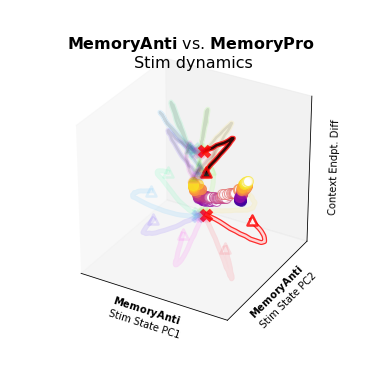

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

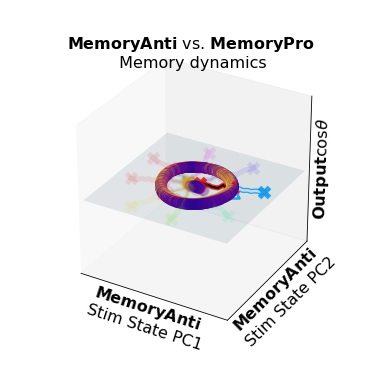

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

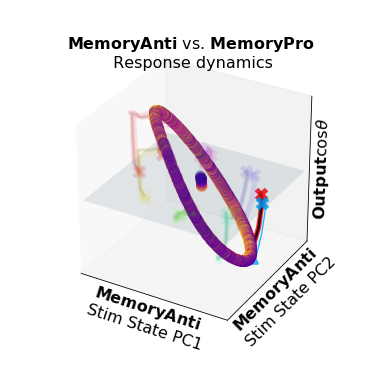

In [10]:
from tools_lnd import make_D_use, interp3d,take_names

script_name = 'interp_tasks_small_init_mov'

rule_set = [5,2]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]

rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)
D_diff = D_fp_qr[:,0]
D_end = D_fp_qr[:,1]
D_use = D_fp_qr[:,:2]

epoch_set = ['stim1','stim1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_stim = make_D_use(m,rule,epoch,ti,axs)

D_use = D_stim
D_use[:,0] = -D_stim[:,0]
D_use[:,1] = -D_stim[:,1]
# D_use[:,2] = D_fix[:,1]
D_use[:,2] = D_fp_qr[:,0]
# D_use[:,2] = w_out[:,2]

interp = True
fig_size = 5
epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
ax_labels = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC3',]

epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .6,plot_zero_plane = False, 
         ax_labels = ax_labels, stability_thresh = 1, z_label = 'Context Endpt. Diff')

epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, epoch_set,trial_num)
D_go = D_use
D_go[:,2] = -D_fp_qr[:,0]

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule],
#          zlabel = 'Memory Endpt. Diff',plot_zero_plane = False, stability_thresh = 1.05)

# interp = False
D_go[:,2] = w_out[:,2]

epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'

interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 1.05)


epoch_set = ['go1','go1']
script_name = 'interp_tasks_small_init_mov'

interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 2)

In [49]:
def plot_bifurc(ax,x_traj,threeD,linestyle = '-',c = 'r',cd = 'k',lw = 6,alpha = 1,ms = 6):

    if threeD:
            plt.plot(x_traj[:,0],x_traj[:,1],x_traj[:,2],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = alpha, 
                     markersize = ms)
            plt.plot(x_traj[:,0],x_traj[:,1],x_traj[:,2],
                     linestyle,
                     c = cd, 
                     linewidth = lw/2, 
                     alpha = np.min((1,alpha*2)), 
                     markersize = ms)
            
            ax.scatter(x_traj[-1,0],x_traj[-1,1],x_traj[-1,2],
                       s = 300,
                       marker = '^',
                       facecolors = cd, 
                       edgecolors = c,
                       linewidth = lw/2, 
                       alpha = alpha)
            ax.scatter(x_traj[0,0],x_traj[0,1],x_traj[0,2],
                       s = 300,
                       marker = 'x',
                       facecolors = c,
                       linewidth = lw/2, 
                       alpha = alpha)
            ax.scatter(x_traj[0,0],x_traj[0,1],x_traj[0,2],
                       s = 200,
                       marker = 'x',
                       facecolors = cd, 
                       linewidth = lw/4, 
                       alpha = alpha)
    else:
            plt.plot(x_traj[:,0],x_traj[:,1],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = alpha, 
                     markersize = ms)
            plt.plot(x_traj[:,0],x_traj[:,1],
                     linestyle,
                     c = cd, 
                     linewidth = lw/2, 
                     alpha = alpha, 
                     markersize = ms)
            
            ax.scatter(x_traj[-1,0],x_traj[-1,1],
                       s = 300,
                       marker = '^',
                       facecolors = cd, 
                       edgecolors = c,
                       linewidth = lw/2, 
                       alpha = alpha)
            ax.scatter(x_traj[0,0],x_traj[0,1],
                       s = 300,
                       marker = 'x',
                       facecolors = c,
                       linewidth = lw/2, 
                       alpha = alpha)
            ax.scatter(x_traj[0,0],x_traj[0,1],
                       s = 200,
                       marker = 'x',
                       facecolors = cd, 
                       linewidth = lw/4, 
                       alpha = alpha)

def axis_label_bifurc(ax,ax_labels,rule_name_ax,epoch_name_ax,bifurc,threeD,fontsize):

    if bifurc:
        ax.set_xlabel(r"Rule Input $\alpha$", fontsize = fontsize, labelpad=10) 

        if ax_labels=='pca_h':
            ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1', labelpad=-5)
            if threeD:
                ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2', labelpad=-5)

        elif ax_labels=='pca_fp':
            ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' FxdPt PC1', labelpad=-5)
            if threeD:
                ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' FxdPt PC2', labelpad=-5)

        else:
            ax.set_ylabel(ax_labels[1], labelpad=-5)
            if threeD:
                ax.set_zlabel(ax_labels[2],labelpad=0)
    else:


        if ax_labels=='pca_h':
            ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1', labelpad=-5)
            ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2', labelpad=-5)
            if threeD:
                ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3', labelpad=-5)

        elif ax_labels=='pca_fp':
            ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' FxdPt PC1', labelpad=-5)
            ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' FxdPt PC2', labelpad=-5)
            if threeD:
                ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' FxdPt PC3', labelpad=-5)

        else:
            ax.set_xlabel(ax_labels[0], labelpad=-5)
            ax.set_ylabel(ax_labels[1], labelpad=-5)
            if threeD:
                ax.set_zlabel(ax_labels[2],labelpad=0)

def title_label_bifurc(bifurc,epoch_name1,epoch_name2,rule_name1,rule_name2,title_y,fontsize):
    
    if bifurc:
        tit_label = ' Bifurcation Diagram'
        tit_save = 'bifurcation'
    else:
        tit_label = ' Dynamics'
        tit_save = 'dynamics'

    if epoch_name1==epoch_name2:
        epoch_name = epoch_name1
        tit = r"$\bf{"+rule_name1+"}$"+' vs. '+r"$\bf{"+rule_name2+"}$"+ '\n '+epoch_name+tit_label
        tit_name = ruleset+'_'+rule_name1+'_v_'+rule_name2+'_'+epoch_name+'_'+tit_save

    elif rule_name1==rule_name2: 
        rule_name = rule_name1
        tit = r"$\bf{"+epoch_name1+"}$"+' vs. '+r"$\bf{"+epoch_name2+"}$"+ '\n '+rule_name+tit_label
        tit_name = ruleset+'_'+epoch_name1+'_v_'+epoch_name2+'_'+rule_name+'_'+tit_save
        
    plt.title(tit,y = title_y, fontsize=fontsize)

    return tit, tit_name, tit_save

def check_plot_zero_plane(ax,plot_zero_plane,label_null = False):
    
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1-.1*abs(x1),x2+.1*abs(x2)])
    ax.set_ylim([y1-.1*abs(y1),y2+.1*abs(y2)])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    
    if plot_zero_plane:
        
        xs = np.linspace(-1, 1, 1000)
        ys = np.sqrt(1 - xs**2)
        xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
        z = xx*0
        ax.plot_surface(xx, yy, z, alpha=0.1)
        ax.set_zlabel(r"$\bf{Output}$"+r'$\cos{\theta}$',labelpad=-10)
        
        if label_null:
            ax.text(x1, y1, 0, 'Output Null', (1,0,0))
            
        ax.set_zlim([-1.1,1.1])
        ax.set_zticks([-1,1])
    

def bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',tol_q = 1e-6,
           cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['w','k'],q_thresh = .001,
           n_skip_interps=1, rule_axs = 0,ax_labels = 'pca_h', plot_unstable = True,
           color_stim = True,fig_size = 4, fontsize = 20, figpath = [],ruleset = [],
           title_y = .9, n_interp = 20,n_trials = 0, stability_thresh = 1, threeD = True,
           lims = [], view_ang = [],lw = 6,ms = 6,linestyle = '-',al_state = 1,al_fp = 1, 
           bifurc = True, plot_zero_plane = False):
    
    plt.rcParams.update({'font.size': fontsize})

    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    if threeD:
        ax = fig.add_axes([0,0,1,1], projection='3d');
    else:
        ax = fig.add_axes([0,0,1,1]);

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

    for ri in range(2):

        cd = cmap_discrete[ri]
        trial = gen_trials_from_model_dir(m,rule_str[ri],mode='test',noise_on = False)
        
        #get traj
        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
        
        #get state colors
        cmap_state = plt.get_cmap('hsv')
        if color_stim:
            c_set = np.min(trial.stim_locs[:,[0,2]],axis=1)
            s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
            c = cmap_state(c_set[s]/max(np.min(trial1.stim_locs[:,[0,2]],axis=1)))
        else:
            c_set = trial.y_loc[-1,:]
            s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
            c = cmap_state(c_set[s]/max(trial1.y_loc[-1,:]))
            
        #plot other trials   
        if n_trials==0:
            trial_set = range(0)
        else:
            trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/n_trials))
            
        for trial_i in trial_set:
            ci = cmap_state(c_set[trial_i]/max(c_set))
            x_traj_i = np.dot(x_epoch[trial_i,:,:],D_use)
            if bifurc:
                x_traj_i[:,2] = x_traj_i[:,1]
                x_traj_i[:,1] = x_traj_i[:,0]
                x_traj_i[:,0] = ri*np.ones(len(T_inds))
            plot_bifurc(ax,x_traj_i,threeD,c = ci,cd = cmap_discrete[ri],lw = lw,alpha = .1,ms = ms)
        
        #plot fp trial
        x_traj = np.dot(x_epoch[s,:,:],D_use)
        if bifurc:
            x_traj[:,2] = x_traj_i[:,1]
            x_traj[:,1] = x_traj_i[:,0]
            x_traj[:,0] = ri*np.ones(len(T_inds))
        plot_bifurc(ax,x_traj, threeD, c = c, cd = cmap_discrete[ri],lw = lw,ms = ms)

        #set x-axis to ri if bifurcation diaram
        if bifurc:
            x_traj[:,0] = ri*np.ones(len(T_inds))
            
    #plot fps
    for step_i in range(0,n_interp,n_skip_interps):
        c = cmap_grad(step_i/n_interp)

        fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                              filename_interp+'_step_'+str(step_i)+'.npz')
        fp_struct = np.load(fp_dir)
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        for fp_ind in range(len(fp_inds)):

            fp = np.dot(sorted_fps[fp_ind,:],D_use)
            facecolors_3d = c
            fp_s = 50

            if bifurc:
                fp[2] = fp[1]
                fp[1] = fp[0]
                fp[0] = step_i/n_interp
            
            #sometimes we don't want to distinguish marginally stable fps so threshold is variable
            if np.max(eig_decomps[fp_ind]['evals'])>stability_thresh:
                if plot_unstable:
                    #open circles for unstable
                    facecolors_3d = 'w'
                    if threeD:
                        ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                           facecolors = facecolors_3d, linewidth = 1/3, alpha = al_fp)
                    else:
                        ax.scatter(fp[0],fp[1],s = fp_s,marker = 'o',edgecolors = c,
                           facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
            else:
                if threeD:
                    ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                           facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                else:
                    ax.scatter(fp[0],fp[1],s = fp_s,marker = 'o',edgecolors = c,
                           facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                    
    axis_label_bifurc(ax,ax_labels,rule_name_ax,epoch_name_ax,bifurc,threeD,fontsize)
    tit, tit_name, tit_save = title_label_bifurc(bifurc,epoch_name1,epoch_name2,rule_name1,
                                                 rule_name2,title_y,fontsize)

    check_plot_zero_plane(ax,plot_zero_plane)
    
    if not bifurc:
        ax.set_xticks([])
        
    ax.set_yticks([])
    
    if threeD:
        
        if not plot_zero_plane:
            ax.set_zticks([])
        
#         if len(lims)>0:
#             ax.set_xlim([1.5*lims[0],1.5*lims[1]])
#             ax.set_zlim([1.5*lims[2],1.5*lims[3]])
#         else:
#             [x1,x2] = ax.get_ylim()
#             [z1,z2] = ax.get_zlim()
#             lims = [x1,x2,z1,z2]
            
        if len(view_ang)>0:
            ax.view_init(elev=view_ang[0], azim=view_ang[1])
        
        ax.dist = 12
        
    else:
        lims = []
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

    fig_fldr = os.path.join(figpath,tit_save,ruleset)
    if not os.path.exists(fig_fldr):
        os.makedirs(fig_fldr)

    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
    plt.show()
    
    return


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) 

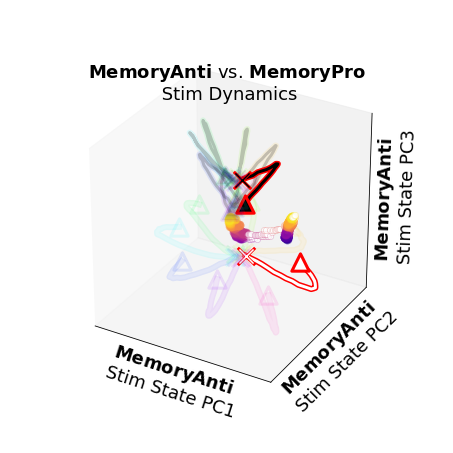

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

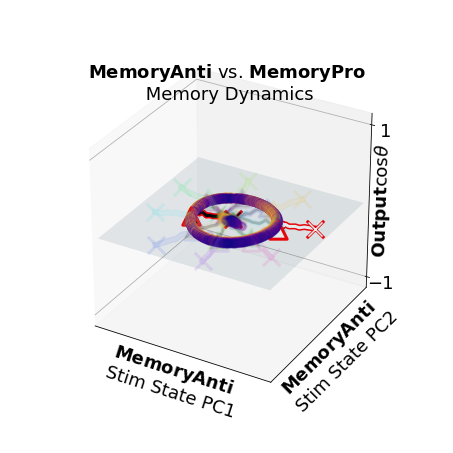

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

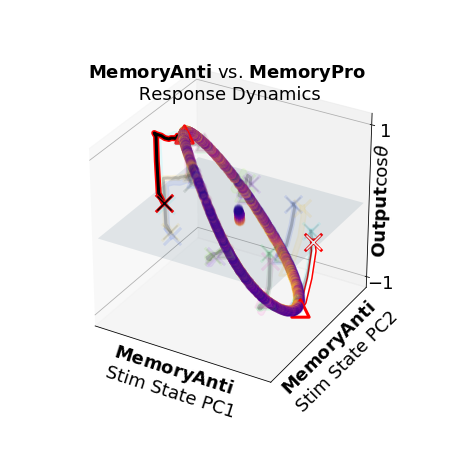

In [50]:
from tools_lnd import make_D_use, take_names, get_interp_filename, same_mov_inds#, bifurc

script_name = 'interp_tasks_small_init_mov'

rule_set = [5,2]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]

rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)
D_diff = D_fp_qr[:,0]
D_end = D_fp_qr[:,1]
D_use = D_fp_qr[:,:2]

epoch_set = ['stim1','stim1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_stim = make_D_use(m,rule,epoch,ti,axs)

D_use = D_stim
D_use[:,0] = -D_stim[:,0]
D_use[:,1] = -D_stim[:,1]
# D_use[:,2] = D_fix[:,1]
D_use[:,2] = D_fp_qr[:,0]
# D_use[:,2] = w_out[:,2]

fig_size = 6
fontsize = 18
n_trials = 8

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
ax_labels = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC3',]

epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,bifurc = False,
         q_thresh = .000001,rule_axs = rule_axs, n_trials = n_trials, 
         color_stim = True,fig_size = fig_size,fontsize = fontsize,
         figpath = figpath,ruleset = ruleset,al_fp = .6,plot_zero_plane = False, 
         ax_labels = ax_labels, stability_thresh = 1,title_y = .85)

epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, epoch_set,trial_num)
D_go = D_use
D_go[:,2] = -D_fp_qr[:,0]

D_go[:,2] = w_out[:,2]

epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'

bifurc(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,bifurc = False,
         q_thresh = .000001,rule_axs = rule_axs, plot_zero_plane = True,title_y = .85,
         color_stim = True,fig_size = fig_size,fontsize = fontsize,n_trials = n_trials, 
         figpath = figpath,ruleset = ruleset,al_fp = .1,ax_labels = ax_labels, stability_thresh = 1.05)


epoch_set = ['go1','go1']
script_name = 'interp_tasks_small_init_mov'

bifurc(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,bifurc = False,
         q_thresh = .000001,rule_axs = rule_axs, plot_zero_plane = True,title_y = .85,
         color_stim = True,fig_size = fig_size,fontsize = fontsize,n_trials = n_trials, 
         figpath = figpath,ruleset = ruleset,al_fp = .1,ax_labels = ax_labels, stability_thresh = 2)

In [ ]:
from tools_lnd import make_D_use, interp3d,take_names

script_name = 'interp_tasks_small_init_mov'

rule_set = [5,2]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]

rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)
D_diff = D_fp_qr[:,0]
D_end = D_fp_qr[:,1]
D_use = D_fp_qr[:,:2]

epoch_set = ['stim1','stim1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_stim = make_D_use(m,rule,epoch,ti,axs)

D_use = D_stim
D_use[:,0] = -D_stim[:,0]
D_use[:,1] = -D_stim[:,1]
# D_use[:,2] = D_fix[:,1]
D_use[:,2] = D_fp_qr[:,0]
# D_use[:,2] = w_out[:,2]

interp = True
fig_size = 5
epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
ax_labels = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC3',]

epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .6,plot_zero_plane = False, 
         ax_labels = ax_labels, stability_thresh = 1, z_label = 'Context Endpt. Diff')

epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, epoch_set,trial_num)
D_go = D_use
D_go[:,2] = -D_fp_qr[:,0]

# interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,alpha_max = 1.05,ax_labels = [epoch, rule],
#          zlabel = 'Memory Endpt. Diff',plot_zero_plane = False, stability_thresh = 1.05)

# interp = False
D_go[:,2] = w_out[:,2]

epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'

interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 1.05)


epoch_set = ['go1','go1']
script_name = 'interp_tasks_small_init_mov'

interp3d(m,D_go,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .000001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 2)

In [11]:
# from tools_lnd import interp_h_tasks_w_context, gen_stim_trial_set

# ruleset = 'all'
# step_file = 'interp_tasks_small_init_mov'

# ri_set = [5,2]
# epoch_list = ['stim1','stim1']
# trial_set = gen_mov_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = step_file,
#                          figpath = figpath,ruleset = ruleset)
# ri_set = [5,2]
# epoch_list = ['delay1','delay1']
# trial_set = gen_mov_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = step_file,
#                          figpath = figpath,ruleset = ruleset)
# ri_set = [5,2]
# epoch_list = ['go1','go1']
# trial_set = gen_mov_trial_set(m, ri_set)
# interp_h_tasks_w_context(m,ri_set,trial_set,epoch_list,step_file = step_file,
#                          figpath = figpath,ruleset = ruleset)


In [12]:
def plot_stim_angles(ax,stim_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False, show_rainbow = True):
        
    stim_cmap = plt.get_cmap('hsv')

    [x1,x2] = ax.get_xlim()
    x_diff = (x2-x1)/10
    [y1,y2] = ax.get_ylim()
    y_diff = (y2-y1)/10
    
    x_origin = x1+5*x_diff
    y_origin = y2+y_diff

    if show_rainbow:
        for theta in stim_locs:
            c = stim_cmap(theta/(2*np.pi))
            plt.plot([x_origin,x_origin+x_diff*np.cos(theta)],
                     [y_origin,y_origin+y_diff*np.sin(theta)],'-',c = c,alpha = .5,linewidth = 5)
        
        if show_stim:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.2,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Stimulus '+r'$\theta$',fontsize = 16,fontweight ='bold')
        else:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.4,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Response '+r'$\theta$',fontsize = 16,fontweight ='bold')
    
    
    if cat_task:
        plt.text(x_origin+x_diff*np.cos(0),y_origin-y_diff*np.sin(np.pi/2),'Category \n Boundary',fontsize = 14)
        plt.plot([x_origin-x_diff*np.cos(np.pi),x_origin+x_diff*np.cos(np.pi)],
                 [y_origin-y_diff*np.sin(np.pi),y_origin+y_diff*np.sin(np.pi)],':k',alpha = .9,linewidth = 3)
        
    if two_task:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = 'dimgray',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = 'dimgray',alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,'Task1',fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = 'dimgray',alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = 'gainsboro',alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = 'gainsboro',alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = 'gainsboro',alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,'Task2',fontsize = 14,verticalalignment='center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])


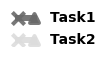

In [13]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(.4,.5),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
stim1_locs = np.min(trial.stim_locs[0:-1:10,[0,2]],axis=1) #only workds for single modality tasks
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = True, show_rainbow = False)

figname = 'task_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'task_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

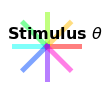

In [14]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False)

figname = 'stim_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'stim_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

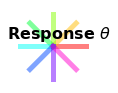

In [15]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = False)

figname = 'response_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'response_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

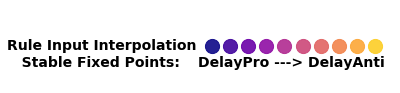

In [16]:
def interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    cmap = plt.get_cmap('plasma')
    for step_i in range(0,n_interp,n_skip_interps):
        c = cmap(step_i/n_interp)
        ax.scatter(step_i-21.5,0,s = 200,marker = 'o',edgecolors = c,facecolors = c,alpha = al)
    plt.text(-n_interp-3,-.06,'DelayPro ---> DelayAnti',fontsize = 14,fontweight ='bold')
    plt.text(-2*n_interp-4,-.06,'Rule Input Interpolation \n   Stable Fixed Points:',fontsize = 14,fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_xlim([y1-3,y2])
    
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(2.6,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)

figname = 'interp_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'interp_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [17]:
# def fp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
#     ax.scatter(0,1,s = 200,marker = 'o',edgecolors = 'k',facecolors = 'w',alpha = al)
#     ax.scatter(0,0,s = 200,marker = 'o',edgecolors = 'k',facecolors = 'k',alpha = al)
#     plt.text(0.04,1,'Unstable',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
#     plt.text(0.04,0,'Stable',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
#     plt.text(-0.04,2,'Fixed Points',fontsize = 14,verticalalignment = 'center',fontweight ='bold')
        
#     remove_ax_lines(ax)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_ylim([y1-1,y2+1])
    
# fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
# ax = fig.add_axes([0, 0, 1, 1])
# fp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)


# figname = 'fp_legend.pdf'
# if not os.path.exists(figpath):
#     os.makedirs(figpath)
# plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

# figname = 'fp.png'
# plt.savefig(os.path.join(figpath,figname))
# plt.show()